# A Human-in-loop Literature Digest for COVID-19 Treatments

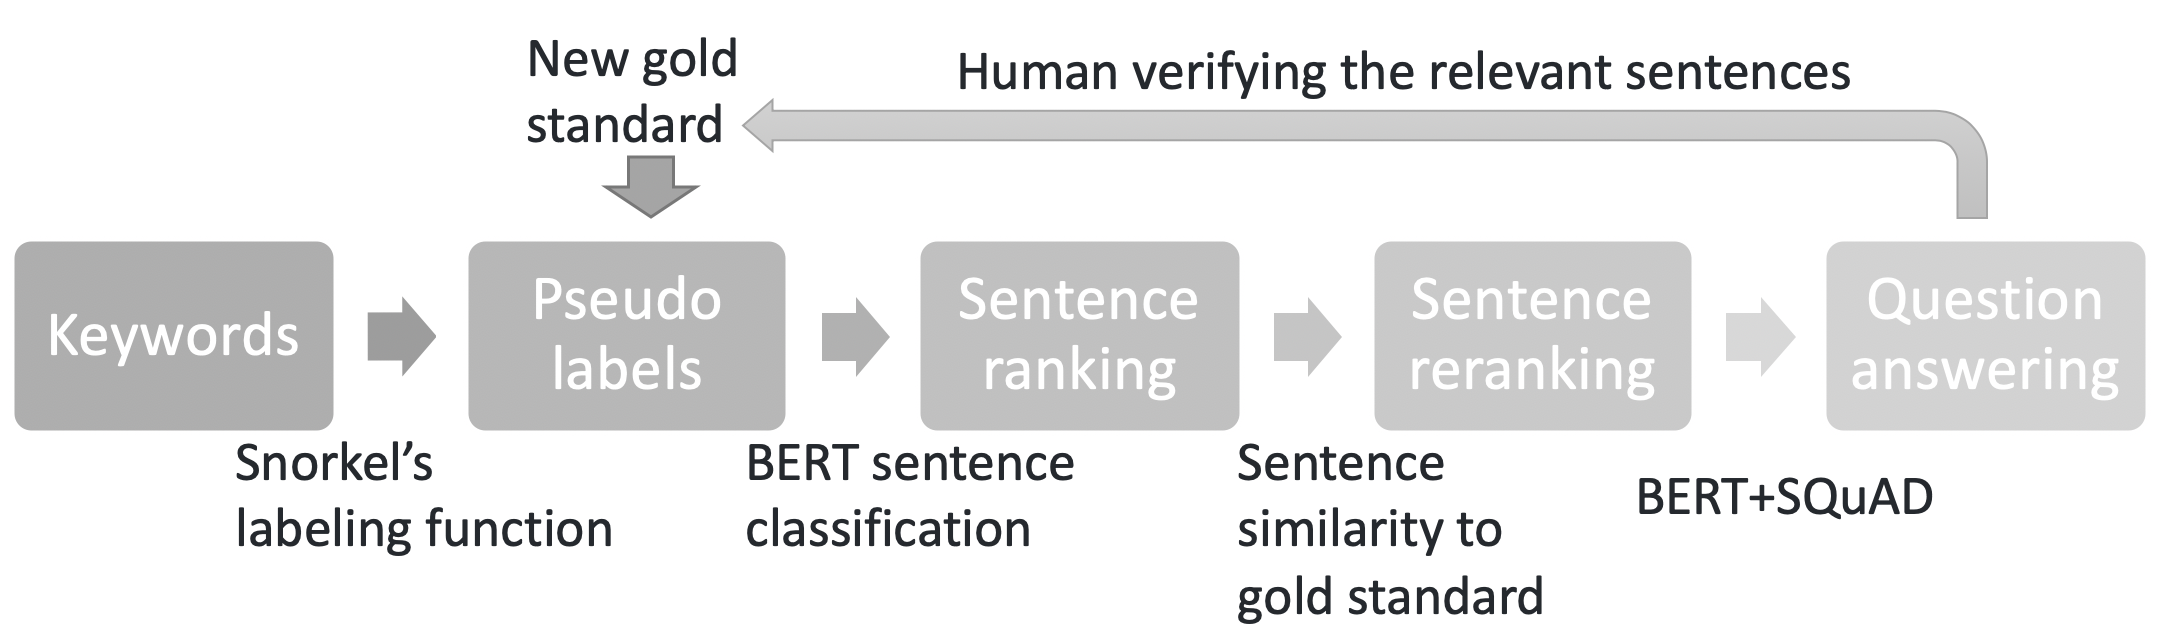



## Summary
This notebook presents the literature review for COVID-19 vaccines and therapeutics. The main strengths are as follows:
- Integrate human feedback loop in the pipeline to seamlessly integrate human expert’s knowledge and machine learning’s computation
- Enhance relevance labels using labeling function in Snorkel



## Objective
To integrate state-of-the-art natural language processing (NLP) techniques and human expert knowledge in a harmonized pipeline for automated extraction of relevant literature for COVID-19 vaccines and therapeutics. 

### Pros
- Rank the relevant sentences by three granularity criteria: keywords inclusion, pseudo labels on relevance, similarity to gold standard sentence 
- Integrate human feedback in the loop
- Enhance relevance labels by combining weak knowledges


### Cons: 
- Manual keywords generation requires subject matter expert's knowledge
- Inclusion of keywords might not be the best way to select relevant documents or sentences
- Sometimes the retrieved sentences can be less accurate depending on the difficulty of defining keywords

## Approach
The pipeline consists of five modules
1. Keywords generation
2. Pseudo labeling of sentences
3. Relevant sentence retrieval and reranking
4. Question Answering

### 1. Keywords generation
We formulated this information retrieval as a semi-supervised learning. We provided an initial small set of gold standards (a set of relevant sentences by reviewing a few papers that accurately answer the given questions). We also provided silver standards via label modeling using [Snorkel](https://www.snorkel.org/). For the ten questions in Task 4, we listed relevant keywords that describe the question in fine-grained concepts (For example, the first question is related to “drugs being developed”, the human experts will find actual drugs that are being developed, such as Remdesivir, hydroxycholoroquine,  Lopinavir, and other under developing COVID-2019 drugs). We used those keywords to search relevant papers within the dataset and generated pseudo labels for the relevance of the sentences to the Task4's questions. To extend the set of limited keywords and find unnoticed drugs, we used [UMLS](https://www.nlm.nih.gov/research/umls/index.html) and applied entity recognition technology to COVID-2019 related documents. Other keywords can came from experts to provide additional informaiton.

### 2. Pseudo labeling of sentences
Then we used those keywords to build combined labeling function by combining drug names and other related information (such as virus name). For the selected documents we annotated each sentence whether relevant or not using the inclusion of the keywords combinations as a silver standard label. These partial and incomplete weak labels were used as initial input to the labeling function implemented in [Snorkel](https://www.snorkel.org/) to derive pseudo labels of remaining sentences without annotations. Human experts further evaluated those labeled sentences that were relevant to the concepts we define or not. The selected sentences are used to train models. Other unknown sentences are predicted by our model. The total number of selected documents for this preliminary pipeline was 3,269. There were 25,739 sentences in this dataset. 


### 3. Relevant sentence retrieval
Once we have a pseudo label on some sentence's relevance, we built a sentence classification model to classify the sentences without a label. Using the pseudo labels, we extracted relevant sentences out of all 25,739 sentences. We used pre-trained BERT) and Sci-BERT for the sentence classification.

### 4. Question Answering
We implemented the question-answering framework to extract key information from the sentences retrieved by previous steps that best address each question. This step uses a publicly available pre-trained BERT model that was fine-tuned with SQuAD dataset for question-answering purposes.

Once we ranked the most relevant sentences to answers for the questions, human experts examined and gave feedback on the validity of each sentence. The human feedback was injected back to the pseudo labeling modules to prioritize the human validated sentences as a gold standard. We repeated the module 2-4 until the extracted sentences converged to human expert’s knowledge. 


## Acknowledgements
[Sci-BERT]()

[BERT]()

[BERT-SQuAD]()

[Snorkel](https://www.snorkel.org/)

[Drug list from Frenkel-Morgenstern Lab](http://mfm-lab.md.biu.ac.il/research/covid19/)



Install requirements

In [ ]:
#!pip install pandas
!pip install tqdm 
!pip install snorkel
!pip install scispacy
!pip install bert_score
!pip install scispacy scipy
!pip install bert-score
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz

Import packages

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm 
import os 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import logging

from snorkel.labeling import PandasLFApplier,LFAnalysis,LabelingFunction
from snorkel.labeling.model.label_model import LabelModel

import nltk
from nltk.tokenize import sent_tokenize,word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable

import spacy
from spacy.matcher import PhraseMatcher
import scispacy
from scispacy.umls_linking import UmlsEntityLinker

import transformers
from transformers import BertTokenizer,BertModel, BertConfig, AdamW,BertForQuestionAnswering
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)
from bert_score import score,scorer


from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')


Define functions for pseudo label

In [ ]:
def build_raw_data (file):
    def retunsb(sentlist,i,lennu):
        sent=sentlist[i]
        if i-1<0:
            present=''
        else:
            present=sentlist[i-1]
        if i+1>=lennu:
            aftsent=''
        else:
            aftsent=sentlist[i+1]
        tempsent=''
        tempsent=tempsent.join( [present, sent, aftsent])
        return tempsent
    allfile=file
    #get alldoucment
    allfile['abstract']=allfile.abstract.astype(str)
    #get allsentence
    allsent=[]
    allid=[]
    allab=[]
    for i in tqdm(range(len(allfile))):
        temp=allfile.abstract.iloc[i]
        temp=sent_tokenize(temp)
        for j in range(len(temp)):
            tempab=retunsb(temp,j,len(temp))
            allsent.append(temp[j])
            allid.append(allfile.pid.iloc[i])
            allab.append(tempab)
            
    allsent=pd.DataFrame(allsent,columns=['sent'])
    allsent['pid']=allid
    allsent['abstract']=allab
    return allfile, allsent

def loop_labing(keylist,valuelist,virus):
    def keyword_lookup(x, keywords, virus ,label):
        y=x.sent.lower()
        print(y)
        print(type(y))
        if any(word in y for word in keywords) and any(word in y for word in virus) :
            return label
        return Norelevent

    def make_keyword_lf(keywords, virus,name,label=None):
        return LabelingFunction(
            name=f"keyword_{name}",
            f=keyword_lookup,
            resources=dict(keywords=keywords,virus=virus ,label=label),
        )
    
    def keyword_lookup1(x, keywords, virus ,label):
        y=x.sent.lower()
        if not any (word in y for word in keywords) and any(word in y for word in virus):
            return label
        return Norelevent

    def make_keyword_lf1(keywords, virus,name,label=None):
        return LabelingFunction(
            name=f"keyword_{name}",
            f=keyword_lookup1,
            resources=dict(keywords=keywords,virus=virus ,label=label),
        )
    #This function has some drawback because I am writing the function to combine previous and latter sentence for a given sentence
    def abstract_lookup(x, keywords,virus,label):
        y=x.abstract.lower()
        if any(word in y for word in keywords)and any(word in y for word in virus):
            return label
        return Norelevent

    def make_abstract_lf(keywords,virus,name,label=None):
        return LabelingFunction(
            name=f"abstract_{name}",
            f=abstract_lookup,
            resources=dict(keywords=keywords,virus=virus,label=label),
        )
    
    Norelevent = -1
    allweaklabf=[]
    viruselist=virus
    for i in range(len(keylist)):
        #labelvalue=i
        labelvalue=1
        vbname=keylist[i]
        vbnameab=vbname+'su'
        globals()[vbname] = make_keyword_lf(keywords=valuelist[i],virus=viruselist,name=vbnameab,label=labelvalue)
        
        vbname1=keylist[i]+'ab'
        vbnameab1=vbname+'su1'
        globals()[vbname1] = make_abstract_lf(keywords=valuelist[i],virus=viruselist,name=vbnameab1,label=labelvalue)
        
        vbname2=keylist[i]+'sent'
        vbnameab2=vbname+'sentno'
        globals()[vbname2] = make_keyword_lf1(keywords=valuelist[i],virus=viruselist,name=vbnameab2,label=0)
     
        allweaklabf.append(globals()[vbname])
        allweaklabf.append(globals()[vbname1])
        allweaklabf.append(globals()[vbname2])
    
    
    return allweaklabf

def snorkel_process (keylist,dataframe,allweaklabf):
    
    cardinalitynu=2
    applier = PandasLFApplier(lfs=allweaklabf)
    all_train_l = applier.apply(df=dataframe)
    report=LFAnalysis(L=all_train_l, lfs=allweaklabf).lf_summary()
    print(report)
    label_model = LabelModel(cardinality=cardinalitynu,verbose=False)
    label_model.fit(all_train_l)
    predt=label_model.predict(all_train_l)
    dataframe['L_label']=predt
    dataframe=dataframe[dataframe.L_label>=0]
    
    train,test=train_test_split(dataframe,test_size=0.2,random_state=234)#123)
    
    trainsent=train.sent.values
    
    trainlabel=train.L_label.values
    
    testsent=test.sent.values
    testlabel=test.L_label.values
    
    return trainsent,trainlabel,testsent,testlabel,keylist,report



Define functions for sentence classification

In [ ]:
def inputid (inputsent,tokenizername):
    tokenizer = BertTokenizer.from_pretrained(tokenizername)
    input_ids = []
    for sent in tqdm(inputsent):
        sent= word_tokenize(sent)[0:500]
        encoded_sent = tokenizer.encode(sent,add_special_tokens = True)
        input_ids.append(encoded_sent)
    return input_ids

def maxwordnum(allsec):
    allsentlen=[]
    for i in tqdm(allsec):
        wordnu=len(i)
        allsentlen.append(wordnu)
    maxnum=max(np.array(allsentlen))
    return maxnum

def dxseqpadding (seq,maxnu):
    seq2=[]
    for i in tqdm(seq):
        stamp=len(i)
        i=np.pad(i,((0,maxnu-stamp)),'constant',constant_values=0)
        seq2.append(i)
    return seq2

def attid (inputsent):
    attention_masks = []
    for sent in tqdm(inputsent):
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return attention_masks
def dataloader (trainval, test,args):
    train_inputs=trainval[0]
    train_inputs = torch.tensor(train_inputs)
    train_labels=trainval[1]
    train_labels = torch.tensor(train_labels)
    train_masks=trainval[2]
    train_masks = torch.tensor(train_masks)
    
    val_inputs=trainval[3]
    val_inputs = torch.tensor(val_inputs)
    val_labels=trainval[4]
    val_labels = torch.tensor(val_labels)
    val_masks=trainval[5]
    val_masks = torch.tensor(val_masks)
    
    test_inputs=test[0]
    test_inputs = torch.tensor(test_inputs)
    test_labels=test[1]
    test_labels = torch.tensor(test_labels)
    test_masks=test[2]
    test_masks = torch.tensor(test_masks)
    train_data = TensorDataset(train_inputs, train_masks, train_labels)    
    train_dataloader = DataLoader(train_data, batch_size=args, shuffle=True)
    
    validation_data = TensorDataset(val_inputs, val_masks, val_labels)    
    validation_dataloader = DataLoader(validation_data, batch_size=args, shuffle=True)
        
    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_dataloader = DataLoader(test_data, batch_size=args, shuffle=True)
    
    return (train_dataloader,validation_dataloader,test_dataloader)
def bert_process (args,trainsent,valsent,testsent,trainlabel,vallabel,testlabel):
    if args['science']==True:       
        trainsci=inputid(trainsent,args['modelname2'])
        valsci=inputid(valsent,args['modelname2'])
        testsci=inputid(testsent,args['modelname2'])
        trainnor=inputid(trainsent,args['modelname1'])
        valnor=inputid(valsent,args['modelname1'])
        testnor=inputid(testsent,args['modelname1'])
        maxnum=maxwordnum(testnor)
        trainsci=dxseqpadding(trainsci,maxnum)
        valsci=dxseqpadding(valsci,maxnum)
        testsci=dxseqpadding(testsci,maxnum)
        trainnor=dxseqpadding(trainnor,maxnum)
        valnor=dxseqpadding(valnor,maxnum)
        testnor=dxseqpadding(testnor,maxnum)
        trainsciatt=attid(trainsci)
        valsciatt=attid(valsci)
        testsciatt=attid(testsci)
        trainnoratt=attid(trainnor)
        valnoratt=attid(valnor)
        testnoratt=attid(testnor)
        nortrainval=(trainnor,trainlabel,trainnoratt,valnor,vallabel,valnoratt)
        scitrainval=(trainsci,trainlabel,trainsciatt,valsci,vallabel,valsciatt)
        scitest=(testsci,testlabel,testsciatt)
        nortest=(testnor,testlabel,testnoratt)
        norloder=dataloader(nortrainval, nortest,int(args['batch_size']))
        sciloder=dataloader(scitrainval, scitest,int(args['batch_size']))
    else : 
            
        trainnor=inputid(trainsent,args['modelname1'])
        valnor=inputid(valsent,args['modelname1'])
        testnor=inputid(testsent,args['modelname1'])
        maxnum=maxwordnum(testnor)
        trainnor=dxseqpadding(trainnor,maxnum)
        valnor=dxseqpadding(valnor,maxnum)
        testnor=dxseqpadding(testnor,maxnum)
        trainnoratt=attid(trainnor)
        valnoratt=attid(valnor)
        testnoratt=attid(testnor)
        nortrainval=(trainnor,trainlabel,trainnoratt,valnor,vallabel,valnoratt)        
        nortest=(testnor,testlabel,testnoratt)
        norloder=dataloader(nortrainval, nortest,int(args['batch_size']))       
        sciloder=[]
    return norloder,sciloder



class bert(nn.Module):
    def __init__(self, args):
        super(bert, self).__init__()
        self.args = args
        self.emb1=BertModel.from_pretrained(self.args['modelname1'],num_labels = 1,output_attentions = False,output_hidden_states = False)#.cuda(3)
        self.emb1_size=self.emb1.config.hidden_size
        if self.args['science']==True:
            self.emb2=BertModel.from_pretrained(self.args['modelname2'],num_labels = 1,output_attentions = False,output_hidden_states = False)#.cuda(3)
            self.emb2_size=self.emb2.config.hidden_size
            self.emb_size=self.emb1_size+self.emb2_size
        else:
            self.emb_size=self.emb1_size
        #self.pool = nn.MaxPool1d(args['pool_kernel_size'])
        #self.bn = nn.BatchNorm1d(self.emb_size)
        self.lin1 = nn.Linear(self.emb_size, self.args['hidden_size'])
        self.dropout = nn.Dropout(args['dropout'])
        self.lin2 = nn.Linear(self.args['hidden_size'], 1)
        
    def forward(self,data1,mask1,data2=None,mask2=None):
        if self.args['science']==True:
            emb1=self.emb1(data1,attention_mask=mask1)
            #pooler_output1=torch.mean(emb1[0], 1)
            #pooler_output1=torch.mean(self.pool(emb1[0].transpose(2,1)),2)
            pooler_output1 = emb1[1]
            emb2=self.emb2(data2,attention_mask=mask2)
            #pooler_output2=torch.mean(emb2[0], 1)
            #pooler_output2=torch.mean(self.pool(emb2[0].transpose(2,1)),2)
            pooler_output2 = emb2[1]
            pooler_output = self.dropout(torch.cat((pooler_output1, pooler_output2), 1))
            pooler_output = nn.functional.relu(self.lin1(pooler_output))
        else:
            emb1 =self.emb1(data1)
            #pooler_output1=torch.mean(emb1[0], 1)
            #pooler_output1=torch.mean(self.pool(emb1[0].transpose(2,1)),2)
            pooler_output1 = self.dropout(emb1[1])
            pooler_output = nn.functional.relu(self.lin1(pooler_output1))

        out = self.lin2(pooler_output)
        return out

def train_(model,loss,optimizer,dataloaders1,epoch,dataloaders2=None):
    model.train()
    allloss=[]
    allbatch=[]
    print('Train')
    if args['science']==True:
        for batch_idx, batch in tqdm(enumerate(zip(dataloaders1, dataloaders2))):
            data1, mask1, target1 = batch[0]
            data2, mask2, target2 = batch[1]
            target1 = Variable(target1).to(args['device'])
            data1 = Variable(data1).to(args['device'])
            mask1=Variable(mask1).to(args['device'])
            data2 = Variable(data2).to(args['device'])
            mask2=Variable(mask2).to(args['device'])
            optimizer.zero_grad()
            out = model.forward(data1,mask1,data2,mask2)
            lossall = loss(out.squeeze(),target1.float().squeeze())            
            lossall = torch.sum(lossall)
            lossall.backward()
            optimizer.step()
            loss1=lossall.item()
            allloss.append(loss1)
            allbatch.append(batch_idx*epoch)
           # pdb.set_trace()

    else:
        for batch_idx, batch in tqdm(enumerate(dataloaders1)):
            data1, mask1, target1 = batch
            target1 = Variable(target1).to(args['device'])
            data1 = Variable(data1).to(args['device'])
            mask1=Variable(mask1).to(args['device'])
            optimizer.zero_grad()
            out = model.forward(data1,mask1)
            lossall = loss(out.squeeze(),target1.float().squeeze())            
            lossall = torch.sum(lossall)
            lossall.backward()
            optimizer.step()
            allloss.append(lossall)
            allbatch.append(batch_idx*epoch)
    return allloss, allbatch

def val_(model,dataloaders1,dataloaders2=None):
    model.eval()
    allout=[]
    alltarget=[]
    print('Validation')
    if args['science']==True:
        for batch_idx, batch in tqdm(enumerate(zip(dataloaders1, dataloaders2))):
            data1, mask1, target1 = batch[0]
            data2, mask2, target2 = batch[1]
            data1 = Variable(data1).to(args['device'])
            mask1=Variable(mask1).to(args['device'])
            data2 = Variable(data2).to(args['device'])
            mask2=Variable(mask2).to(args['device'])
            with torch.no_grad(): 
                out = torch.nn.functional.sigmoid(model.forward(data1,mask1,data2,mask2))
            out=out.cpu().detach().numpy()
            #target=target1.to('cpu').numpy().astype(int)
            target=target1.numpy().astype(int)
            
            allout.append(list(out))
            alltarget.append(list(target))
    else:
        for batch_idx, batch in tqdm(enumerate(dataloaders1)):
            data1, mask1, target1 = batch
            #target1 = Variable(target1).cuda()
            data1 = Variable(data1).to(args['device'])
            mask1=Variable(mask1).to(args['device'])
            with torch.no_grad(): 
                out = torch.nn.functional.igmoid(model.forward(data1,mask1,target1))
            out=out.cpu().detach().numpy()
            target=target1.numpy().astype(int)
            
            allout.append(list(out))
            alltarget.append(list(target))
    return allout,alltarget
def test_(model,dataloaders1,dataloaders2=None):
    model.eval()
    allout=[]
    alltarget=[]
    allattn=[]
    print('test')
    if args['science']==True:
        for batch_idx, batch in tqdm(enumerate(zip(dataloaders1, dataloaders2))):
            data1, mask1, target1 = batch[0]
            data2, mask2, target2 = batch[1]
            #target1 = Variable(target1).cuda()
            data1 = Variable(data1).to(args['device'])
            mask1=Variable(mask1).to(args['device'])
            #target2 = Variable(target2).cuda()
            data2 = Variable(data2).to(args['device'])
            mask2=Variable(mask2).to(args['device'])
            with torch.no_grad(): 
                out = torch.nn.functional.sigmoid(model.forward(data1,mask1,data2,mask2))
            out=out.cpu().detach().numpy()
            target=target1.numpy().astype(int)
            
            allout.append(out)
            alltarget.append(target)
            #allattn.append(attn)
    else:
        for batch_idx, batch in tqdm(enumerate(dataloaders1)):
            data1, mask1, target1 = batch
            #target1 = Variable(target1).cuda()
            data1 = Variable(data1).to(args['device'])
            mask1=Variable(mask1).to(args['device'])
            with torch.no_grad(): 
                out = torch.nn.functional.sigmoid(model.forward(data1,mask1))
            out=out.cpu().detach().numpy()
            target=target1.numpy().astype(int)
            
            allout.append(out)
            alltarget.append(target)
            #allattn.append(attn)
    return allout,alltarget,
def result(result):
    alllist=[]
    for i in result:
        for j in i:
            alllist.append(j)
    return alllist

def matcher (nlp, terms):
    patterns = [nlp(text) for text in terms]
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add("TerminologyList", None, *patterns)
    return matcher

def reportfu(dataframe, pidlist,matcher,nlp):
    allmatchnu=[]
    for doc in dataframe.sent.values:
        doc=nlp(str(doc))
        matches = matcher(doc)
        allmatch=[]
        for match_id, start, end in matches:
            rule_id = nlp.vocab.strings[match_id]
            span = doc[start : end]
            allmatch.append(span)
        matchnu=len(allmatch)
        allmatchnu.append(matchnu)
    return allmatchnu

def retrain_sentece_classification(keylist,valuelist,viruslist,allsent):
    print('retrain')
    allweaklabf=loop_labing(keylist,valuelist,viruslist)
    trainsent,trainlabel,valsent,vallabel,keylist,report=snorkel_process (keylist,allsent,allweaklabf)
    testsent=allsent.sent.values
    testlabel=allsent.newpid.values
    num_labels=1
    norloder,sciloder=bert_process(args,trainsent,valsent,testsent,trainlabel,vallabel,testlabel)
    #torch.cuda.set_device(args["device"])
    model= bert(args)
    model=model.to(args["device"])
    params=model.parameters()
    optimizer = AdamW(params,lr = 2e-5, eps = 1e-8 )
    loss = nn.BCEWithLogitsLoss()
    alloss=[]
    allbatch=[]
    dev_lrl=0
    vallrl=[]
    testpred=[]
    testpid=[]
    current_early_stop_times=0
    for epoch in range(1, args['epochs'] + 1):
        epochloss, epochbatch=train_(model,loss,optimizer,norloder[0],epoch,dataloaders2=sciloder[0])
        alloss.append(epochloss)
        allbatch.append(epochbatch)
        #print('BCE training loss: ', np.mean(alloss))
        allout,alltarget=val_(model,norloder[1],sciloder[1])
        allout1=result(allout)
        alltarget1=result(alltarget)
        epochlrl=average_precision_score(alltarget1,allout1)
        vallrl.append(epochlrl)
        if epochlrl >= dev_lrl:
            print("- new best auc{}".format(epochlrl))
            allout,alltarget=test_(model,norloder[2],sciloder[2])
            allout=result(allout)
            alltarget=result(alltarget)
            #allattn=result(allattn)
            allpd=pd.DataFrame(allout,columns=keylist)
            allpd['newpid']=alltarget
            dev_lrl = epochlrl
            current_early_stop_times = 0
        else:
            current_early_stop_times += 1
            print(current_early_stop_times)
        if current_early_stop_times >= args['early_stop_times'] :
            break;
    print ("- early stopping {} epochs without improvement".format(epoch))
    return allpd



Define functions for reranking

In [ ]:
def retrain_reranking(allsent, input_file_dir,gold):
    print('rerank')
    import en_core_sci_sm
    nlp = en_core_sci_sm.load()
    #nlp = spacy.load('en_core_sci_sm')
    linker = UmlsEntityLinker(resolve_abbreviations=True)
    nlp.add_pipe(linker)
    allpd=allpd.merge(allsent)
    alllabel1=pd.DataFrame()
    for i in tqdm(range(len(keylist))) :
        newdata=allpd[['newpid',keylist[i],'sent','pid']].sort_values(by=keylist[i],ascending =False)
        matchers=matcher(nlp, valuelist[i])
        pidlist=newdata.newpid.values  
        allmatchnu=reportfu(newdata, pidlist,matchers,nlp)
        allmatchnu1=np.where(np.array(allmatchnu) >0, 1, 0)
        newdata['label']=allmatchnu1
        newdata=newdata.rename(columns={keylist[i]:'predict_prob'})
        newdata['category']=[keylist[i]]*len(newdata)
        alllabel1=pd.concat([newdata,alllabel1])
    refg=alllabel1[alllabel1.pid.isin(gold.pid.values)]
    refg=alllabel1
    refg=refg.sort_values(['predict_prob','label'], ascending=[False, True])
    refg=refg[(refg.label==1) & (refg.predict_prob>=0.8)]
    refg=refg[['newpid','sent','category']].drop_duplicates()
    cand=alllabel1[['newpid','sent','category']].drop_duplicates()
    categorylist=list(cand.category.drop_duplicates())
    allframe=pd.DataFrame()
    for i in tqdm(range(len(categorylist))):
        refg1=refg[refg.category==categorylist[i]]
        refgsent=list(refg1.sent.values)
        refgsentn=len(refgsent)
        cand1=cand[cand.category==categorylist[i]]
        candsent=list(cand1.sent.values)
        candsentn=len(candsent)
        if refgsentn==0:
            sentence=candsent
            score1=[0]*candsentn
            category=[categorylist[i]]*candsentn
            tempframe=pd.DataFrame(sentence,columns=['sent'])
            tempframe['score']=score1
            tempframe['category']=category
            allframe=pd.concat([allframe,tempframe])
        else :
            testrefsent=[]
            testcandsent=[]
            for j in range(len(candsent)):
                for k in range(len(refgsent)):
                    testrefsent.append(refgsent[k])
                    testcandsent.append(candsent[j])
            P, R, F1 = score(testcandsent, testrefsent, lang='en-sci', verbose=False)
            sentence_candidates=testcandsent
            score1=list(F1.numpy())
            tempframe=pd.DataFrame(sentence,columns=['sent'])
            tempframe['score']=score1
            tempframe=tempframe.groupby('sent').mean().reset_index()
            category=[categorylist[i]]*len(tempframe)
            tempframe['category']=category
            allframe=pd.concat([allframe,tempframe])
        
    allframe=allframe.sort_values(by=['category','score'],ascending=False).drop_duplicates()
    allframe1=allframe.merge(alllabel1)
    allframe1=allframe1[['newpid','pid','category','score','predict_prob','label']]
    allframe1=allframe1.sort_values(['score','label','predict_prob' ], ascending=[False,False, False])
    goldframe=pd.DataFrame()
    for i in categorylist:
        tempframe1=allframe1[allframe1.category==i].head(n=50)    
        tempframe1=tempframe1[tempframe1.label==1]
        tempframe1['real_label']=[1]*len(tempframe1)
        tempframe2=allframe1[allframe1.category==i].tail(n=50)    
        tempframe2=tempframe2[tempframe2.label==0]
        tempframe2['real_label']=[0]*len(tempframe2)
        tempframe=pd.concat([tempframe1,tempframe2])
        goldframe=pd.concat([goldframe,tempframe])
    allframe2=pd.DataFrame()
    for i in categorylist:
        tempframe=allframe1[allframe1.category==i]
        goldframe1=goldframe[goldframe.category==i]
        allx=tempframe[['score','predict_prob','label']].values
        goldx=goldframe1[['score','predict_prob','label']].values
        goldy=goldframe1[['real_label']].values
        fit=SGDRegressor()
        fit.fit(X=goldx ,y=goldy)
        ally=fit.predict(allx)
        tempframe['newscore']=ally
        tempframe=tempframe.sort_values(by='newscore',ascending=False)
        allframe2=pd.concat([tempframe,allframe2])
    allframe2=allframe2[['newpid','pid','category','newscore']]
    alllabel12=alllabel1[['pid','newpid','category','sent']]
    alllabel12=alllabel12.merge(allframe2).sort_values(by=['category','newscore'],ascending=False)
    sentence_candidates=alllabel12[:1000]
    #alllabel12.to_csv(input_directory+'ALLRanking_TASK4_Q1.csv')
    #alllabel13=alllabel12[0:1000]
    #alllabel14=allfile[allfile.pid.isin(alllabel13.pid.values)]
    #alllfile4.to_csv(input_directory+'ALLRanking_TASK4_Q7_1000_abstract.csv')
    return sentence_candidates

Define functions for question answering

In [ ]:
def load_pretrained_qa_model(model_str=None, use_cuda=True):
    if model_str is None:
        model_str = 'bert-large-uncased-whole-word-masking-finetuned-squad'
        device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
    
    tokenizer = BertTokenizer.from_pretrained(model_str)
    model = BertForQuestionAnswering.from_pretrained(model_str).to(device)

    model.eval()
    return tokenizer, model

def answer_question(question, document, model, tokenizer):
    device = model.device
    
    encoded = tokenizer.encode_plus(question, document, return_tensors='pt', max_length=512)
    start_scores, end_scores = model(encoded['input_ids'].to(device),
                                     token_type_ids=encoded['token_type_ids'].to(device))

    tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'].squeeze())
    ans_start, ans_end = torch.argmax(start_scores), torch.argmax(end_scores)
    
    ans_tokens = tokens[ans_start: ans_end+1]
    if '[SEP]' in ans_tokens:
        ans_tokens = ans_tokens[ans_tokens.index('[SEP]')+1:]
    ans = tokenizer.convert_tokens_to_string(ans_tokens)
    ans = ans.replace(' - ', '-').replace('[CLS]', '')
    ans_score = start_scores.max() + end_scores.max()

    return ans, ans_score.item()

def ask_all_possible_questions(question_list, keyword_list, sentence):
    answers = []
    for keyword, question in zip(keyword_list, question_list):
        ans, score = answer_question(question, sentence, model, tokenizer)
        if ans != '':
            answers.append((ans, score, keyword, question))
    if len(answers) == 0:
        return '', '', ''
    answers, scores, keywords, questions = zip(*answers)
    ans_idx = np.argmax(scores)
    return answers[ans_idx], keywords[ans_idx], questions[ans_idx]

def answer_all_possible_questions(question_file, sentences_df, output_file):
#     sentences_df = pd.read_csv(sentence_file, usecols=range(1, 6))
    
    keyword_question_df = pd.read_csv(question_file, 
                                      header=None, names=['keyword', 'question'])
    keyword_list = keyword_question_df['keyword'].tolist()
    question_list = keyword_question_df['question'].tolist()
        
    sentences = sentences_df['sent'].tolist()
    answers = []
    for i in tqdm(range(len(sentences))):
        sent = sentences[i]
        ans = ask_all_possible_questions(question_list, keyword_list, sent)
        answers.append(ans)
    
    ans_lst, val_lst, ques_lst = zip(*answers)
    sentences_df = sentences_df.assign(answer=ans_lst)
    sentences_df = sentences_df.assign(keyword=val_lst)
    sentences_df = sentences_df.assign(question=ques_lst)
    
    sentences_df.to_csv(output_file)
    
    return sentences_df

Preload the question answering model

In [ ]:
tokenizer, model = load_pretrained_qa_model()

Define function for loading keywords

In [ ]:
def load_keywords_list(input_file_dir):
    keylist=[]
    with open(input_file_dir+'keylist.txt', "r") as f:
        alist =f.read().splitlines()
        for line in alist:
            keylist=line.split(',')
    valuelist = []
    with open(input_file_dir+'valuelist.txt', "r") as f:
        alist =f.read().splitlines()
        alist =[x.lower() for x in alist ]
        for line in alist:
            valuelist.append(line.split(','))
    viruslist = []
    with open(input_file_dir+'viruslist.txt', "r") as f:
        alist =f.read().splitlines()
        for line in alist:
            viruslist=line.split(',')
            viruslist =[x.lower() for x in viruslist]
    return keylist, valuelist, viruslist

Configurate models, saving directory, loading directory, etc

In [ ]:
#Configuration 
args={#retrain options
      "retrain-sentence-classification": False, # retrain sentence classification model
      "retrain-reranking":False, # rerun the reranking model
      "retrain-qa": False, #retrain question answering model
      "results_dir": '/kaggle/input/kagglecovid19literature/results/',
    
      #saved intermediate files
      'original_abstract_file': 'NIH_ab.csv', #abstracts containing the keywords
      'sentence_ranking_file': 'Bert_NIH_task4.csv', #retrieved sentences
      'sentence_reranking_file': 'ALLRanking_TASK4_1000.csv', #reranked retrieved sentences
      'ranked_abstract_file': 'ALLRanking_TASK4_1000_abstract.csv', #abstract containing the retrieved sentences
      'specific_questions_file': 'question_list.csv', #fine-graind specific questions for general question
      'answer_file': 'answers_top1000.csv', #answers to questions with given retrieved sentences
      "device": torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu'),
    
      #sentence classification model's parameters
      "modelname1":'bert-base-uncased', 
      "modelname2":'allenai/scibert_scivocab_uncased',
      "hidden_size":256,
      "dropout":0.2,
      "batch_size":10,
      "epochs":100,
      "lr":0.001,
      "seed": 1,
      "early_stop_times":5,
      "science":True
}

# Question 1
Rephrase the general question:
> Effectiveness of drugs being developed and tried to treat COVID-19 patients

into specific questions:
> Can ritonavir treat COVID-19 

> Can lopinavir treat COVID-19

> Can darunavir treat COVID-19

> Can AZT treat COVID-19

> Can nelfinavir treat COVID-19

and 80 other questions.

Set input directory

In [ ]:
question='Q1' 
question_dir=question+'/'

input_file_dir=args["results_dir"]+question_dir

Load necessary keywords input

In [ ]:
keylist, valuelist, viruslist = load_keywords_list(input_file_dir)

Here is example of `valuelist`. We tried to seek a specific concept to mine specific and accurate sentences.

In [ ]:
valuelist[0][:10]

Load original abstract files containing the keywords. This will be the subset of data we will focus.

In [ ]:
fullab=pd.read_csv(input_file_dir+args['original_abstract_file'])
allfile, allsent=build_raw_data(fullab)
allsent['newpid']=range(len(allsent))

Example of sentence

In [ ]:
allsent.sent[0].lower()

## Pseudo labeling and Sentence classification

Based on the keywords, we will 
1. generate pseudo label for the relevance of the sentences
2. learn a classification model to classify the sentence is relevent to the question or not
3. retrieve the top 1000 most confident sentences.

In [ ]:
if args['retrain-sentence-classification']:
    allpd=retrain_sentece_classification(keylist, valuelist, viruslist, allsent)
else:
    allpd=pd.read_csv(input_file_dir+args['sentence_ranking_file'])


Our results are here - ranked list of relevant sentences.

In [ ]:
allpd.merge(allsent)[['newpid', 'sent']]

## Reranking

Given the retrieved sentences, we rerank them based on human feedback on the relevance of the sentences. 

`gold` is a list of `pid` that human experts think reliable. For the first initial learning, we don't have `gold` yet. Just set it as `None`. If `gold` is provided, we will rerank the sentences as prioritizing the `gold` and sentences similar to `gold`.

In [ ]:
gold=None

In [ ]:
if args['retrain-reranking']:
    if gold is None:
        gold=pd.read_csv(input_file_dir+'NIH_ab_COVID.csv')
    sentence_candidates=retrain_reranking(allsent, input_file_dir,gold)
else:
    sentence_candidates=pd.read_csv(input_file_dir+args['sentence_reranking_file'])

Re-ranked list of relevant sentences

In [ ]:
sentence_candidates[['newpid', 'sent', 'newscore']].head()

## Question Answering

In [ ]:
if args['retrain-qa']:
    output_file = '/kaggle/working/' + question + '_answers_top1000.csv'
    answer_df = answer_all_possible_questions(input_file_dir+args['specific_questions_file'], 
                                              sentence_candidates, 
                                              output_file)
else:
    answer_df = pd.read_csv(input_file_dir+args['answer_file'])

In [ ]:
answer_df[['newpid','question', 'answer']].head()

Human can review the answers and select the most reliable answers. Our subject matter experts reviewed and selected the following sentences as listed in `reliable_answers`. 

Note that we have `qgrid` to interactively check the relevance of sentences, but we failed to load them in Kaggle kernel.

In [ ]:
reliable_answers=[627, 684, 816, 829, 543, 752, 1096, 626, 571, 590]
gold=answer_df[answer_df['newpid'].isin(reliable_answers)]


Now we are going back to `retrain_reranking` and repeat until our models answer correctly and human experts satify with the answers. Just a few iteration would be enough:)

If you finish the human-machine feedback loops, let us summarize the literature using word cloud.

In [ ]:
text= sentence_candidates.sent[0]
wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white").generate(text)
text = " ".join(review for review in sentence_candidates.sent)
print ("There are {} words in the combination of all review.".format(len(text)))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=1000,background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



# Question 2
Rephrase the general question:
> Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.

into specific questions:
> Are epitopes and antibodies involved in antibody dependent enhancement

> What immune response are involved in ADE

> Are sustained inflammation, lymphopenia, and/or cytokine storm involved in ADE

> Are SARS-CoV vaccines involved in immunopathology

> What mouse models are involved in SARS-CoV vaccines

and 13 other questions.


Set input directory

In [ ]:
question='Q2' 
question_dir=question+'/'

input_file_dir=args["results_dir"]+question_dir

Load necessary keywords input

In [ ]:
keylist, valuelist, viruslist = load_keywords_list(input_file_dir)

Load original abstract files containing the keywords

In [ ]:
fullab=pd.read_csv(input_file_dir+args['original_abstract_file'])
allfile, allsent=build_raw_data(fullab)
allsent['newpid']=range(len(allsent))

Example of sentence

In [ ]:
allsent.sent[0].lower()

## Pseudo labeling and Sentence classification

In [ ]:
if args['retrain-sentence-classification']:
    allpd=retrain_sentece_classification(keylist, valuelist, viruslist, allsent)
else:
    allpd=pd.read_csv(input_file_dir+args['sentence_ranking_file'])


Ranked list of relevant sentences

In [ ]:
allpd.merge(allsent)[['newpid', 'sent']]

## Reranking

Given the retrieved sentences, we rerank them based on human feedback on the relevance of the sentences. 

`gold` is a list of `pid` that human experts think reliable. For the first initial learning, we don't have `gold` yet. Just set it as `None`. If `gold` is provided, we will rerank the sentences as prioritizing the `gold` and sentences similar to `gold`.

In [ ]:
gold=None

In [ ]:
if args['retrain-reranking']:
    if gold is None:
        gold=pd.read_csv(input_file_dir+'NIH_ab_COVID.csv')
        sentence_candidates=retrain_reranking(allsent, input_file_dir,gold)
else:
    sentence_candidates=pd.read_csv(input_file_dir+args['sentence_reranking_file'])

Re-ranked list of relevant sentences

In [ ]:
sentence_candidates[['newpid', 'sent', 'newscore']].head()

## Question Answering

In [ ]:
if args['retrain-qa']:
    output_file = '/kaggle/working/' + question + '_answers_top1000.csv'
    answer_df = answer_all_possible_questions(input_file_dir+args['specific_questions_file'], 
                                              sentence_candidates, 
                                              output_file)
else:
    answer_df = pd.read_csv(input_file_dir+args['answer_file'])

In [ ]:
answer_df[['newpid','question', 'answer']].head()

Human can review the answers and select the most reliable answers

In [ ]:
reliable_answers=[1399, 39101, 2780, 7160, 8116, 603, 2045, 3018, 12996, 15990]
gold=answer_df[answer_df['newpid'].isin(reliable_answers)]


Now we are going back to `retrain_reranking` and repeat until the human experts satify with the answers

If you finish the human-machine feedback loops, let us summarize the literature using word cloud.

In [ ]:
text= sentence_candidates.sent[0]
wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white").generate(text)
text = " ".join(review for review in sentence_candidates.sent)
print ("There are {} words in the combination of all review.".format(len(text)))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=1000,background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




# Question 3
Rephrase the general question:
>  Exploration of use of best animal models and their predictive value for a human vaccine.

into specific questions:
> What animal models are used to evaluate SARS-CoV

> are mice models used to evaluate the SL-CoV vaccine

> Do mice models increase IFN-Œ≥ by DNA vaccines

> Can vaccinated mice prevent MERS-Cov

> Are mice and monkeys used to test vaccine

and 7 other questions.


Set input directory

In [ ]:
question='Q3' 
question_dir=question+'/'

input_file_dir=args["results_dir"]+question_dir

Load necessary keywords input

In [ ]:
keylist, valuelist, viruslist = load_keywords_list(input_file_dir)

Load original abstract files containing the keywords

In [ ]:
fullab=pd.read_csv(input_file_dir+args['original_abstract_file'])
allfile, allsent=build_raw_data(fullab)
allsent['newpid']=range(len(allsent))

Example of sentence

In [ ]:
allsent.sent[0].lower()

## Pseudo labeling and Sentence classification

Based on the keywords, we will i) generate pseudo label for the relevance of the sentences, ii) learn a classification model to classify the sentence is relevent to the question or not, iii) retrieved the top 1000 most confident sentences.

In [ ]:
if args['retrain-sentence-classification']:
    allpd=retrain_sentece_classification(keylist, valuelist, viruslist, allsent)
else:
    allpd=pd.read_csv(input_file_dir+args['sentence_ranking_file'])


Ranked list of relevant sentences

In [ ]:
allpd.merge(allsent)[['newpid', 'sent']]

## Reranking

Given the retrieved sentences, we rerank them based on human feedback on the relevance of the sentences. 

`gold` is a list of `pid` that human experts think reliable. For the first initial learning, we don't have `gold` yet. Just set it as `None`. If `gold` is provided, we will rerank the sentences as prioritizing the `gold` and sentences similar to `gold`.

In [ ]:
gold=None

In [ ]:
if args['retrain-reranking']:
    if gold is None:
        gold=pd.read_csv(input_file_dir+'NIH_ab_COVID.csv')
    sentence_candidates=retrain_reranking(allsent, input_file_dir,gold)
else:
    sentence_candidates=pd.read_csv(input_file_dir+args['sentence_reranking_file'])

Re-ranked list of relevant sentences

In [ ]:
sentence_candidates[['newpid', 'sent', 'newscore']].head()

## Question Answering

In [ ]:
if args['retrain-qa']:
    output_file = '/kaggle/working/' + question + '_answers_top1000.csv'
    answer_df = answer_all_possible_questions(input_file_dir+args['specific_questions_file'], 
                                              sentence_candidates, 
                                              output_file)
else:
    answer_df = pd.read_csv(input_file_dir+args['answer_file'])

In [ ]:
answer_df[['newpid','question', 'answer']].head()

Human can review the answers and select the most reliable answers

In [ ]:
reliable_answers=[24397, 23799, 22874, 5207, 4015, 4797, 13057, 35129, 13470, 18611] 
gold=answer_df[answer_df['newpid'].isin(reliable_answers)]


Now we are going back to `retrain_reranking` and repeat until the human experts satify with the answers

If you finish the human-machine feedback loops, let us summarize the literature using word cloud.

In [ ]:
text= sentence_candidates.sent[0]
wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white").generate(text)
text = " ".join(review for review in sentence_candidates.sent)
print ("There are {} words in the combination of all review.".format(len(text)))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=1000,background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



# Question 7
Rephrase the general question:

> Efforts to develop animal models and standardize challenge studies

into specific questions:

> Are mice and rats used to evaluate the lethal challenge

> Are young and senescent mice associated with the homologous and heterologous challenge

> Are standardized intranasal challenges and DNA immunization associated with mice models

> Are SARS-CoV mice models associate with heterologous challenges

> Are rodents and primates used to test robust protection from the lethal dose of virus



Set input directory

In [ ]:
question='Q7' 
question_dir=question+'/'

input_file_dir=args["results_dir"]+question_dir

Load necessary keywords input

In [ ]:
keylist, valuelist, viruslist = load_keywords_list(input_file_dir)

Load original abstract files containing the keywords

In [ ]:
fullab=pd.read_csv(input_file_dir+args['original_abstract_file'])
allfile, allsent=build_raw_data(fullab)
allsent['newpid']=range(len(allsent))

Example of sentence

In [ ]:
allsent.sent[0].lower()

## Pseudo labeling and Sentence classification

Based on the keywords, we will i) generate pseudo label for the relevance of the sentences, ii) learn a classification model to classify the sentence is relevent to the question or not, iii) retrieved the top 1000 most confident sentences.

In [ ]:
if args['retrain-sentence-classification']:
    allpd=retrain_sentece_classification(keylist, valuelist, viruslist, allsent)
else:
    allpd=pd.read_csv(input_file_dir+args['sentence_ranking_file'])


Ranked list of relevant sentences

In [ ]:
allpd.merge(allsent)[['newpid', 'sent']]

## Reranking

Given the retrieved sentences, we rerank them based on human feedback on the relevance of the sentences. 

`gold` is a list of `pid` that human experts think reliable. For the first initial learning, we don't have `gold` yet. Just set it as `None`. If `gold` is provided, we will rerank the sentences as prioritizing the `gold` and sentences similar to `gold`.

In [ ]:
gold=None

In [ ]:
if args['retrain-reranking']:
    if gold is None:
        gold=pd.read_csv(input_file_dir+'NIH_ab_COVID.csv')
    sentence_candidates=retrain_reranking(allsent, input_file_dir,gold)
else:
    sentence_candidates=pd.read_csv(input_file_dir+args['sentence_reranking_file'])

Re-ranked list of relevant sentences

In [ ]:
sentence_candidates[['newpid', 'sent', 'newscore']].head()

## Question Answering

In [ ]:
if args['retrain-qa']:
    output_file = '/kaggle/working/' + question + '_answers_top1000.csv'
    answer_df = answer_all_possible_questions(input_file_dir+args['specific_questions_file'], 
                                              sentence_candidates, 
                                              output_file)
else:
    answer_df = pd.read_csv(input_file_dir+args['answer_file'])

In [ ]:
answer_df[['newpid','question', 'answer']].head()

Human can review the answers and select the most reliable answers

In [ ]:
reliable_answers= [5041, 13724, 4688, 7153, 9964, 11546, 10794, 12358, 3191, 12086]
gold=answer_df[answer_df['newpid'].isin(reliable_answers)]


Now we are going back to `retrain_reranking` and repeat until the human experts satify with the answers

If you finish the human-machine feedback loops, let us summarize the literature using word cloud.

In [ ]:
text= sentence_candidates.sent[0]
wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white").generate(text)
text = " ".join(review for review in sentence_candidates.sent)
print ("There are {} words in the combination of all review.".format(len(text)))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=1000,background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



Aggregated visualization is here
https://github.com/yejinjkim/kaggle-covid19-literature/blob/master/kaggle_scattertext.html